## Fig.3.B Generalization Examples

In [8]:
import json

# 文件路径配置
images_txt_path = 'datasets/trials/gen_example.txt'
json_file_path = 'datasets/trials/object_img_5_3_42.json'
output_json_path = 'datasets/trials/filtered_output_with_consistent_counters.json'

# 读取图片列表
with open(images_txt_path, 'r') as file:
    images = [line.strip() for line in file]

# 读取 JSON 数据
with open(json_file_path, 'r') as file:
    data = json.load(file)

# 初始化一个新列表来存储过滤后的数据
filtered_data = []

# 创建字典来跟踪每张图片的 `target_category` 编号
image_counters = {}
category_counter = 1  # 用于为每个新图片类别分配新的编号

# 过滤数据
for image_path in images:
    if image_path not in image_counters:  # 如果这是我们第一次看到这张图片
        image_counters[image_path] = category_counter
        category_counter += 1  # 为下一个新的图片类别准备编号

    # 为当前图片应用已确定的编号
    for item in data:
        if item["target_img_filename"] == image_path:
            new_item = item.copy()
            category_prefix = new_item["target_category"].rstrip('0123456789')  # 去除可能存在的数字
            new_item["target_category"] = f"{category_prefix}{image_counters[image_path]}"
            filtered_data.append(new_item)

# 保存过滤并更新后的数据到新的 JSON 文件
with open(output_json_path, 'w') as file:
    json.dump(filtered_data, file, indent=4)

print(f"Filtered data with consistent counters saved to {output_json_path}")

Filtered data with consistent counters saved to datasets/trials/filtered_output_with_consistent_counters.json


In [2]:
import matplotlib.pyplot as plt
import json

with open('results/trial_08-20_02:44.json', 'r') as file:
    results = json.load(file)
    results = results['class_accuracy']
print(results)

{'butterfly1': 0.8, 'butterfly2': 0.8, 'butterfly3': 0.0, 'butterfly4': 0.0, 'bucket5': 0.0, 'bucket6': 0.0, 'bucket7': 0.0, 'bucket8': 0.0, 'button9': 0.0, 'button10': 0.0, 'button11': 0.0, 'button12': 0.2, 'spoon13': 0.6, 'spoon14': 0.6, 'spoon15': 0.2, 'spoon16': 0.2}


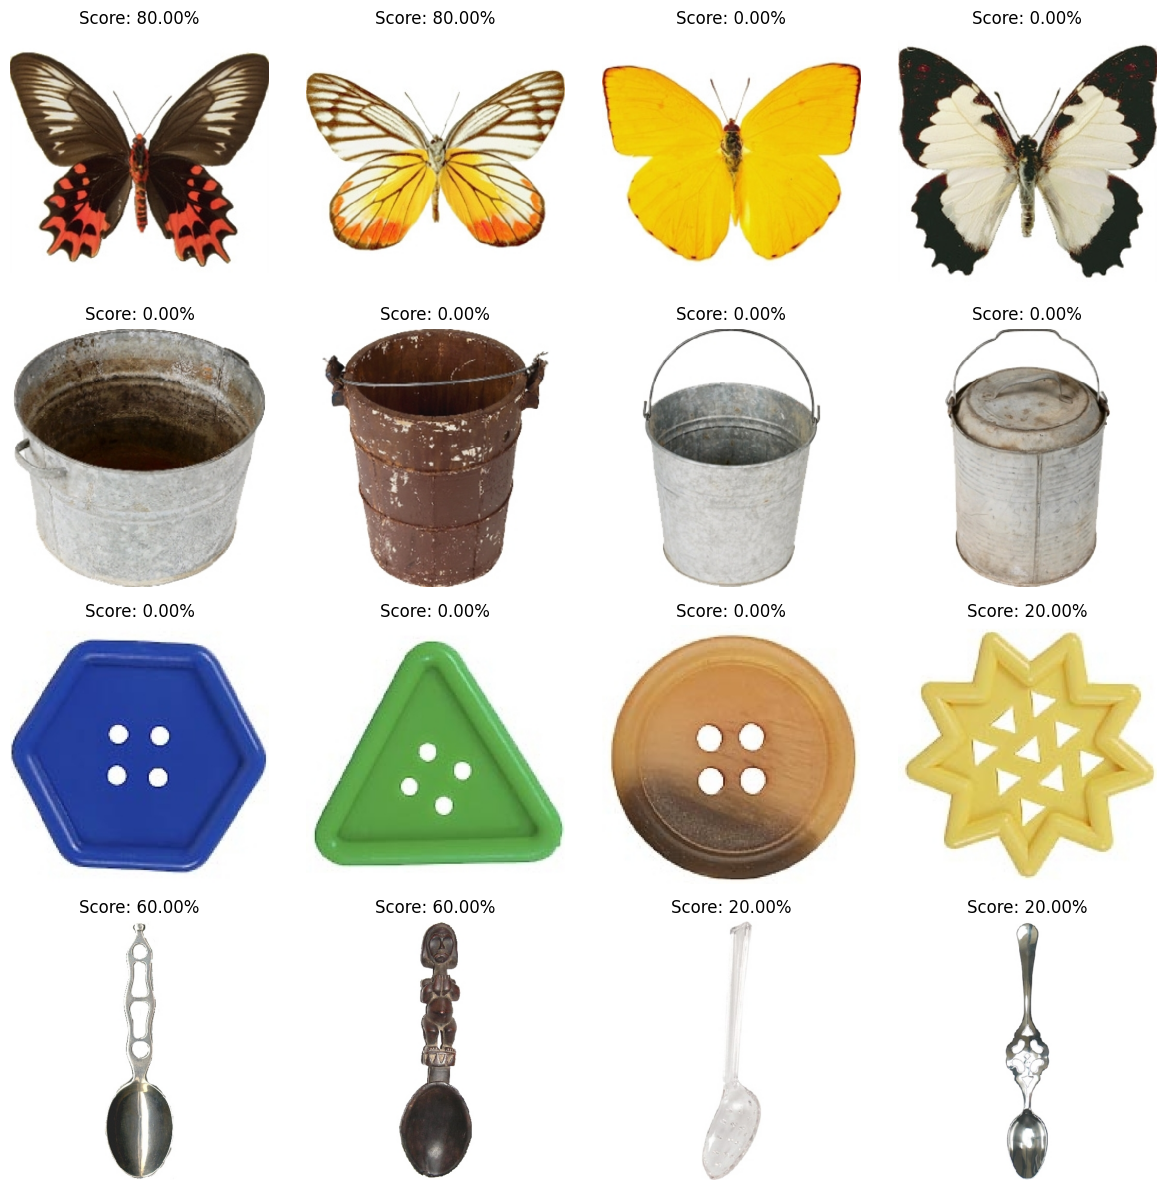

In [12]:
import matplotlib.pyplot as plt
import json

# Load class accuracies
class_accuracies = {'butterfly1': 0.8, 'butterfly2': 0.8, 'butterfly3': 0.0, 'butterfly4': 0.0, 'bucket5': 0.0, 'bucket6': 0.0, 'bucket7': 0.0, 'bucket8': 0.0, 'button9': 0.0, 'button10': 0.0, 'button11': 0.0, 'button12': 0.2, 'spoon13': 0.6, 'spoon14': 0.6, 'spoon15': 0.2, 'spoon16': 0.2}

# Load image filenames
with open('datasets/trials/gen_example.json', 'r') as file:
    image_data = json.load(file)
    image_filenames = {entry['target_category']: entry['target_img_filename'] for entry in image_data}

# Setup the plot
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

# Plot each image with its score
for i, (class_name, accuracy) in enumerate(class_accuracies.items()):
    img_path = image_filenames[class_name]
    if not img_path.startswith('/'):  # Check if the path is already absolute
        img_path = f'datasets/trials/{img_path}'  # Correct the path
    img = plt.imread(img_path)  # Read the image
    axes[i].imshow(img)
    axes[i].set_title(f'Score: {accuracy * 100:.2f}%')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

/tmp/ipykernel_28536/1711424239.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=35, ha='right', fontsize=10)
/tmp/ipykernel_28536/1711424239.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=35, ha='right', fontsize=10)


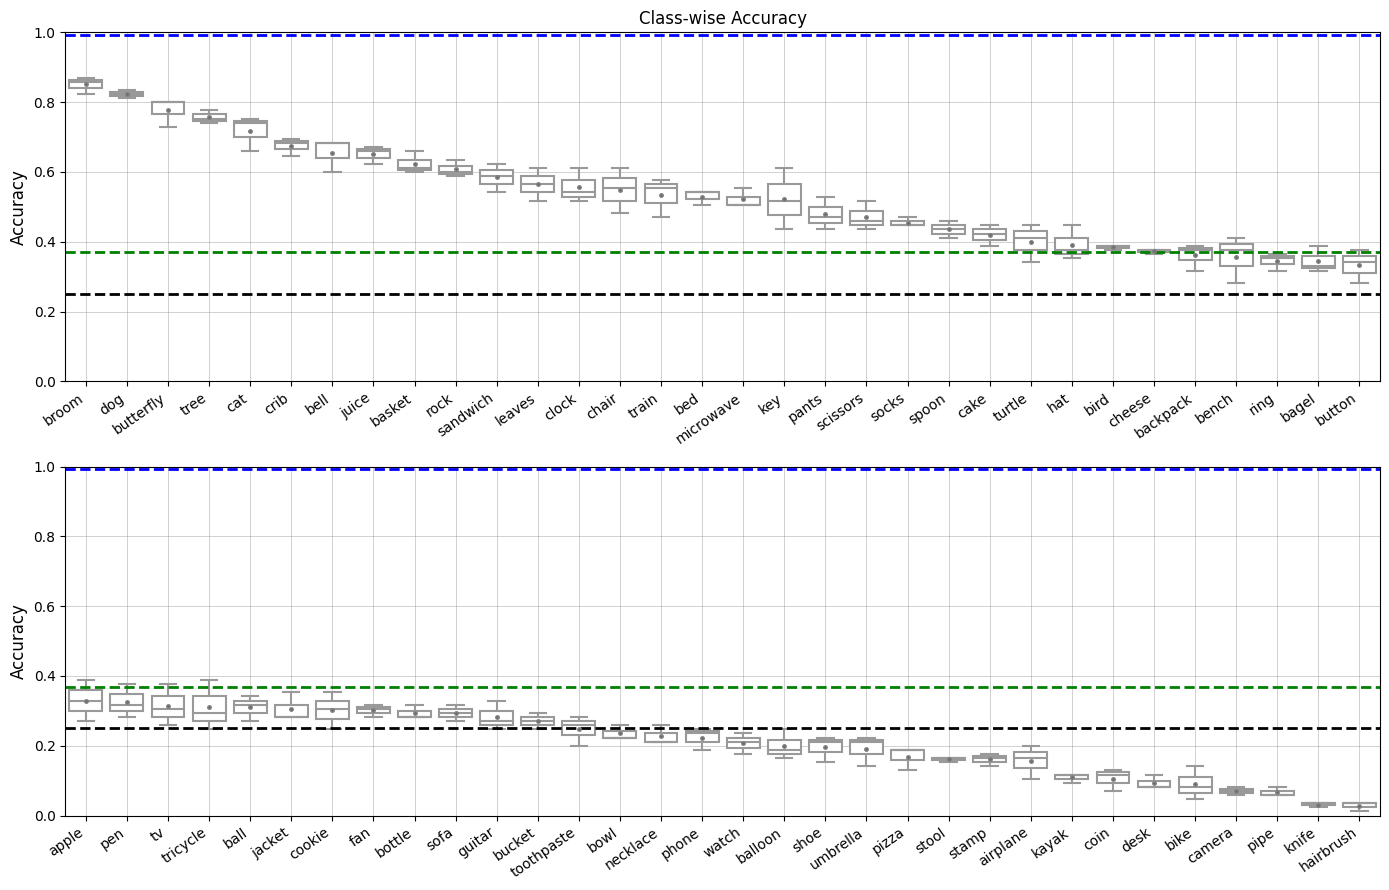

In [81]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns

files = glob.glob('results/trial_*_08-20_*.json')
data_list = []
cvcl_overall_acc = []
clip_overall_acc = []

for file in files:
    with open(file, 'r') as f:
        data = json.load(f)
        if data['args']['model'] != 'clip':
            cvcl_overall_acc.append(data['overall_accuracy'])
            for category, accuracy in data['class_accuracy'].items():
                seed = file.split('_')[1].split('.')[0]
                data_list.append({
                    'Category': category,
                    'Accuracy': accuracy,
                    'Seed': seed
                })
        elif data['args']['model'] == 'clip':
            clip_overall_acc.append(data['overall_accuracy'])

cvcl_avg = np.mean(cvcl_overall_acc)
clip_avg = np.mean(clip_overall_acc)

df_all = pd.DataFrame(data_list)
df_all['Mean_Accuracy'] = df_all.groupby('Category')['Accuracy'].transform('mean')
df_all = df_all.sort_values(by='Mean_Accuracy', ascending=False)

categories = df_all['Category'].unique()
half = len(categories) // 2
first_half = categories[:half]
second_half = categories[half:]

df_first_half = df_all[df_all['Category'].isin(first_half)]
df_second_half = df_all[df_all['Category'].isin(second_half)]

fig, axs = plt.subplots(2, 1, figsize=(14, 9), sharey=True)

# Mean properties for the mean point
meanpointprops = dict(marker='o', markeredgecolor='gray', markerfacecolor='dimgrey', markersize=2.5)  

sns.boxplot(x='Category', y='Accuracy', data=df_first_half, ax=axs[0], color='white',
            fliersize=2, linewidth=1.5, showmeans=True, meanprops=meanpointprops)
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=35, ha='right', fontsize=10)
axs[0].set_title('Class-wise Accuracy', fontsize=12)
axs[0].set_ylabel('Accuracy', fontsize=12)
axs[0].set_xlabel('')

sns.boxplot(x='Category', y='Accuracy', data=df_second_half, ax=axs[1], color='white',
            fliersize=2, linewidth=1.5, showmeans=True, meanprops=meanpointprops)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=35, ha='right', fontsize=10)
axs[1].set_ylabel('Accuracy', fontsize=12)
axs[1].set_xlabel('')

for ax in axs:
    ax.axhline(y=0.25, color='black', linestyle='--', linewidth=2.0)
    ax.axhline(y=cvcl_avg, color='green', linestyle='--', linewidth=2.0)
    ax.axhline(y=clip_avg, color='blue', linestyle='--', linewidth=2.0)
    ax.grid(True, linestyle='-', linewidth='0.5', color='gray', alpha=0.5)
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()